# Figure out what makes good sleep

The purpose of this analysis is to determine what factors, as measured by my fitbit charge hr (version 1, not the new fancy one), contribute to good sleep. 

Please note that this won't all be done in chronological order. If I complete the whole thing, then come back and do some visualisations at the beginning, I won't rewrite later parts to make sense. Keep that in mind. 

In [1]:
# IMPORT ALL THE THINGS!
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from xgboost import XGBRegressor
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Also some settings
pd.set_option('max_columns', None)

In [3]:
fitbit_v1_data_file_path = '../input/dataInCsvFormat/fitbitDataV1.csv'
fitbit_v1_data = pd.read_csv(fitbit_v1_data_file_path)

# fitbit_v1_data.describe()
len(fitbit_v1_data.columns)

27

Wow, apparently the minimum calories I expend each day just being alive is 1679. And my mean caloriesOut per day is 3030! Go me! Cool. 

In [4]:
train_column_names = fitbit_v1_data.columns.drop('date').drop('totalMinutesAsleep').drop('totalSleepRecords').drop('totalTimeInBed')
X = fitbit_v1_data[train_column_names]
y = fitbit_v1_data.totalMinutesAsleep

OK so I have my X and y sets

In [5]:
def getTestTrainSplits(X, y):
    return train_test_split(X, y, test_size=0.3, train_size=0.7)
xTrain, xTest, yTrain, yTest = getTestTrainSplits(X, y)

And I've got some train/test split. I find that any test is worth doing on different randomly selected train/test splits, so I've made a function to neaten that up a bit in later code, and also called it to provide a train/test split that is available to use as I code things. 

Now I'll check to see what a good `max_depth` is for this dataset. I've just left `n_estimators=200` because that's a good large number and gradient boosting doesn't overfit super easily. 

In [6]:
xTrain, xTest, yTrain, yTest = getTestTrainSplits(X, y)
for d in [3,4,5,6,7,8,9]:
    tuning_gbr = GradientBoostingRegressor(n_estimators=200, max_depth=d, random_state=0)
    tuning_gbr.fit(xTrain, yTrain)
    tuning_predictions = tuning_gbr.predict(xTest)
    print("max_depth="+str(d)+", mae="+str(mean_absolute_error(yTest, tuning_predictions)))

max_depth=3, mae=80.04506323036244
max_depth=4, mae=79.91345580459225
max_depth=5, mae=82.96454895709456
max_depth=6, mae=80.40445576894334
max_depth=7, mae=80.33977407485655
max_depth=8, mae=80.75123977926131
max_depth=9, mae=78.24523554517918


OK so the results vary between (very occasionally) 60 and (occasionally) 100, mostly around the 70-90 range. Is that good? Well no because we're talking in minutes here and an accuracy of plus/minus AN HOUR AND A HALF is useless when that's 18.75%~20% of desired sleep time. 

I'll try with `max_leaf_nodes` and see what that does. 

In [7]:
xTrain, xTest, yTrain, yTest = getTestTrainSplits(X, y)
for l in [5, 25, 50, 250, 500, 2500, 5000]:
    tuning_gbr = GradientBoostingRegressor(n_estimators=200, max_depth=5, max_leaf_nodes=l, random_state=0)
    tuning_gbr.fit(xTrain, yTrain)
    tuning_predictions = tuning_gbr.predict(xTest)
    print("max_leaf_nodes="+str(l)+"\t\tmea="+str(mean_absolute_error(yTest, tuning_predictions)))

max_leaf_nodes=5		mea=71.4362409499271
max_leaf_nodes=25		mea=74.53258073012854
max_leaf_nodes=50		mea=72.84398193383802
max_leaf_nodes=250		mea=72.71880825590982
max_leaf_nodes=500		mea=72.71880825590982
max_leaf_nodes=2500		mea=72.71880825590982
max_leaf_nodes=5000		mea=72.71880825590982


`max_leaf_nodes=50` comes out best most of the times I run this. 

I would be using other methods here, but I'm restricting myself to those that are easy to make graphs of how different features affect the target variable because the objective of this analysis is to _determine what factors contribute to good sleep_. 

I will use `GradientBoostingRegressor` with `n_estimators=200` and `max_depth=6` and `max_leaf_nodes=50` and see what `plot_partial_dependence` shows me. 

[0.04665617 0.06869161 0.04765471 0.04708422 0.04364846 0.04570652
 0.01123415 0.04371045 0.03695182 0.05843324 0.05202686 0.06591526
 0.02813907 0.02861009 0.03246622 0.07180908 0.08477813 0.04731837
 0.07491066 0.01364807 0.03275622 0.00393983 0.0139108 ]


/home/chhk/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


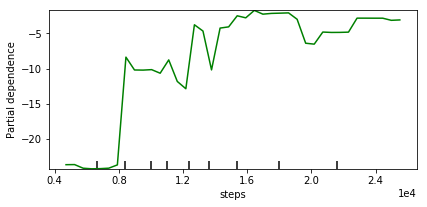

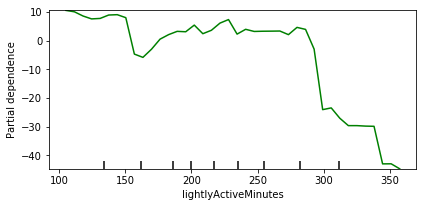

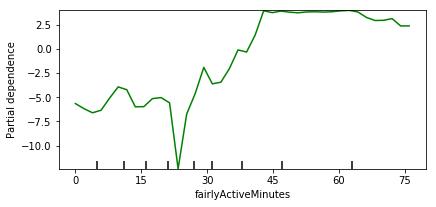

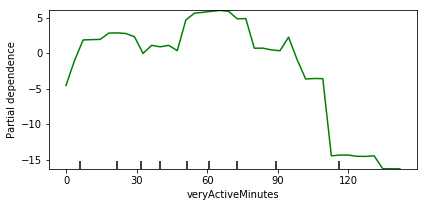

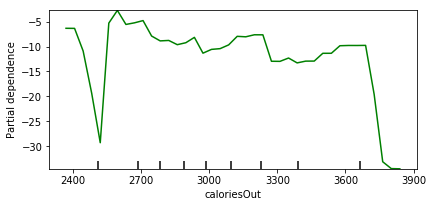

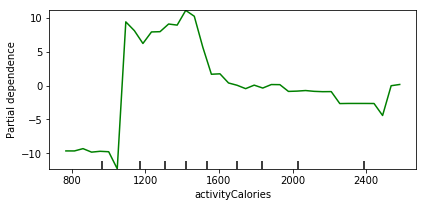

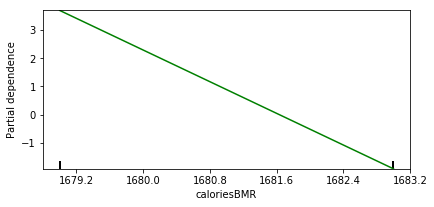

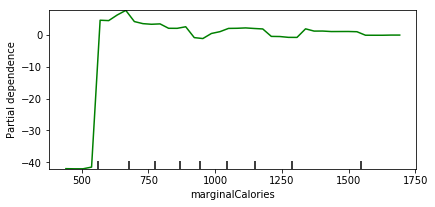

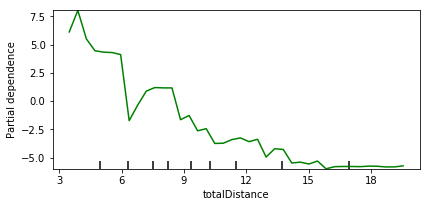

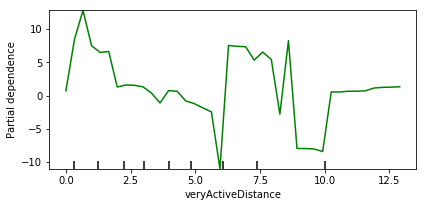

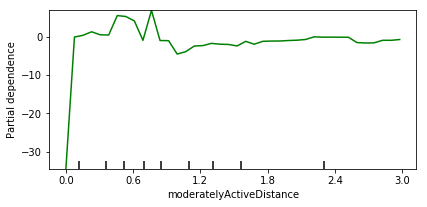

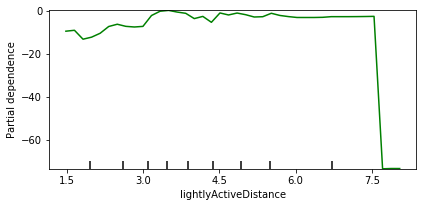

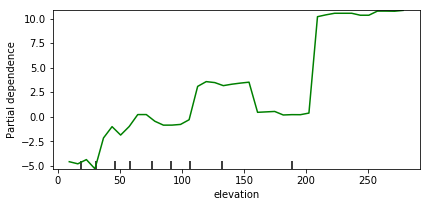

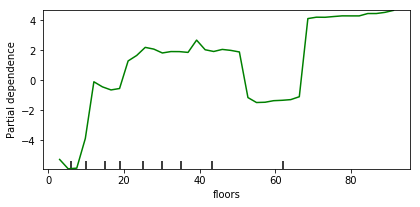

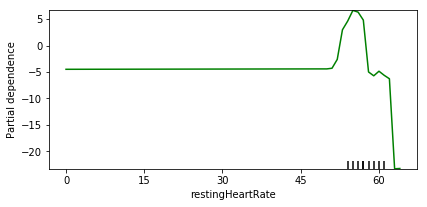

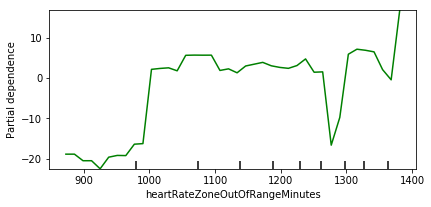

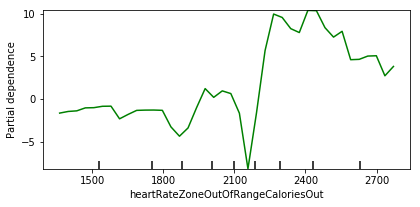

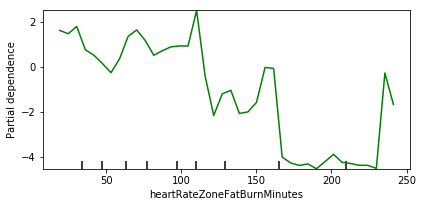

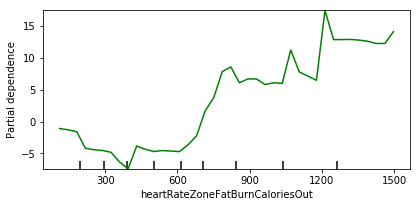

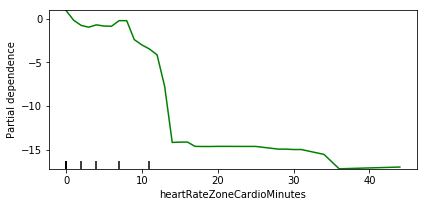

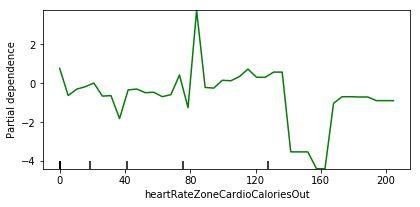

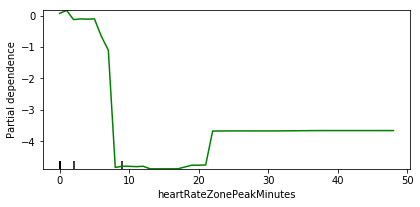

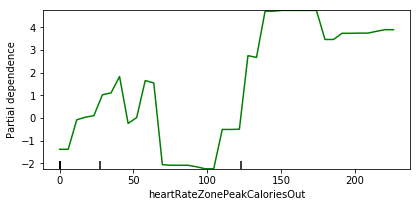

In [8]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=6, max_leaf_nodes=50)
gbr.fit(X, y)
print(gbr.feature_importances_)
for f in range(len(train_column_names)):
    plot = plot_partial_dependence(gbr, features=[f], X=X, feature_names=train_column_names, grid_resolution=40)
    

Well that's a lot of graphs, I guess I'll look through and see which tell me useful things. 
* Steps: up to ~10,000 it seems have an effect on sleep, past ~11,000 and it drops of into the steep negatives. That's unexpected - I predicted a linear(ish) relationship here. 
* Lightly active minutes: Other than a strange blip around 160, sleep minutes appear to be related to lightly active minutes up until about ~280 - after that it is not a useful predictor for sleep. 
* Fairly active minutes: sleep isn't dependent on this unless a minimum of ~40 minutes has been achieved. 
* Very active minutes: as I thought, very active minutes has a very strong effect on sleep. 
* Calories out: unexpectedly, sleep has little dependence on overall calorie expenditure. 
* Activity calories: the number of calories expended in activities is shown to have a massive effect on sleep. 
* Calories BMR: Basically how many you burn just by existing - I don't think this is of any use at all, given that it only varies by 3 calories and I can't control it. 
* Marginal calories: this mostly has a strong effect on sleep only when it's between ~600 and ~850. 
* Total distance: total distances effect on sleep is only meaningful up to about 8 KM. 
* Very active distance: a very variable graph - perhaps I require some outlier clean up in my data - which shows that it has a strong effect most of the time. 
* Moderately active distance: little effect past about 0.8 KM. 
* Lightly active distance: has little effect on sleep. 
* Elevation: at low levels (0~75) has no effect, after that has huge effects on sleep. Apparently hills matter. 
* Floors: after 10 and besides a strange blip later on, floors have a meaningful effect on sleep. 
* Resting heart rate: has an effect on sleep, thought given how small the range of values for resting heart rate is, and how little control I have over it in a single day, perhaps it's useless for this. 
* Heart rate zone out of range minutes: this is how much time I have a normal heart rate, and it's got a strong effect on sleep. 
* Heart rate zone out of range calories out: not so meaningful until the higher numbers, then it becomes very meaningful. 
* Heart rate zone fat burn minutes: very variable graph, but the first two hours of fat burn appear to have some meaningful effect on sleep, but not consistently. 
* Heart rate zone fat burn calories out: very meaningful _after_ ~800 calories. 
* Heart rate zone cardio minutes: very low effect on sleep minutes. 
* Heart rate zone cardio calories out: a highly variable graph that shows little dependence on this for sleep minutes. 
* Heart rate zone peak minutes: little to no effect - unexpected. I thought hard exercise would help with sleep. 
* Heart rate zone peak calories out: inconsistent, until about 120 calories after which it becomes extremely effective. 

Keep in mind that the heart rate tracking of the fitbit over ~125 is absolutely atrocious. Maybe higher heart rate data effect is so variable due to this. 

So, some things have a very strong effect, some have a very weak effect, some are super variable. I should look at some correlation graphs, and for that I need to go learn how to do cool graphs brb. 

OK back now after a graphing tutorial. Let's look at which of the above are worth looking at again in detail. 

- Steps
- Lightly active minutes
- Fairly active minutes
- Very active minutes
- Activity calories
- Total distance
- Very active distance
- Elevation (at high numbers)
- Floors (same as elevation) 
- Heart rate zone Out of range Calories out
- Heart rate zone Fat burn Calories out
- Heart rate zone Peak Calories out

Some correlation graphs with each of these against sleep minutes, individually: 

In [9]:
# First, a List of what's useful
factors_that_affect_sleep = ['steps', 'lightlyActiveMinutes', 'fairlyActiveMinutes', 'veryActiveMinutes', 'activityCalories', 
 'totalDistance', 'veryActiveDistance', 'elevation', 'floors', 'heartRateZoneOutOfRangeCaloriesOut', 
 'heartRateZoneFatBurnCaloriesOut', 'heartRateZonePeakCaloriesOut']

Actually, you know what, before _any_ of that, lets do some correlation calculations. 
Treated as independent variables, the following are how correlated each feature is with how long I spent asleep (specifically totalMinutesAsleep): 

In [10]:
data = fitbit_v1_data.corr()
numeric_correlation = data['totalMinutesAsleep']
numeric_correlation

totalMinutesAsleep                    1.000000
totalSleepRecords                     0.616212
totalTimeInBed                        0.891873
steps                                 0.121508
lightlyActiveMinutes                  0.038911
fairlyActiveMinutes                   0.146238
veryActiveMinutes                     0.153561
caloriesOut                           0.145284
activityCalories                      0.160081
caloriesBMR                          -0.059741
marginalCalories                      0.170487
totalDistance                         0.122760
veryActiveDistance                    0.134282
moderatelyActiveDistance              0.115678
lightlyActiveDistance                 0.010690
elevation                             0.105811
floors                                0.105814
restingHeartRate                      0.253064
heartRateZoneOutOfRangeMinutes        0.252076
heartRateZoneOutOfRangeCaloriesOut    0.184784
heartRateZoneFatBurnMinutes           0.127068
heartRateZone

Errrr wat? Nothing other than time in bed and number of sleep records has correlation above 0.25. 
Are they all useless? 
What does that even mean? 
I can't understand how it's useful. Probably because it's not super useful. What I really want to know, if how much they correlate with time spent sleeping being within a target range that I desire. 

Better make a target range before I get annoyed at how much time and effort has been wasted on this fitbit project (read: years). 

In [11]:
# 7hr30 minutes is (7*60)+30=450, 8hr15mins is (8*60)+15=495 (round to 500 for no reason. )
fitbit_v1_1_data = fitbit_v1_data.copy(deep=True)
column_name_totalMinutesAsleep = 'totalMinutesAsleep'

below_450 = fitbit_v1_1_data[column_name_totalMinutesAsleep] < 450
fitbit_v1_1_data.loc[below_450, column_name_totalMinutesAsleep] = 0

above_500 = fitbit_v1_1_data[column_name_totalMinutesAsleep] > 500
fitbit_v1_1_data.loc[above_500, column_name_totalMinutesAsleep] = 0

between_450_and_500 = fitbit_v1_1_data[column_name_totalMinutesAsleep] > 0
fitbit_v1_1_data.loc[between_450_and_500, column_name_totalMinutesAsleep] = 1

What does correlation do now?

In [12]:
data = fitbit_v1_1_data.corr()
classif_correlation = data['totalMinutesAsleep']
classif_correlation

totalMinutesAsleep                    1.000000
totalSleepRecords                     0.066815
totalTimeInBed                        0.232707
steps                                 0.008051
lightlyActiveMinutes                 -0.071997
fairlyActiveMinutes                   0.028325
veryActiveMinutes                     0.049891
caloriesOut                          -0.002349
activityCalories                      0.005469
caloriesBMR                           0.013566
marginalCalories                      0.023095
totalDistance                         0.013252
veryActiveDistance                    0.061153
moderatelyActiveDistance              0.023809
lightlyActiveDistance                -0.080532
elevation                             0.027093
floors                                0.027095
restingHeartRate                      0.047544
heartRateZoneOutOfRangeMinutes        0.021787
heartRateZoneOutOfRangeCaloriesOut   -0.025283
heartRateZoneFatBurnMinutes           0.027108
heartRateZone

## Total and massive failure? 
These correlations are even smaller, for what I have determined to be good sleep (7hr30min to 8hr20min). This is disheartening. 

Not to worry, perhaps the noisiness of the data can be reduced, and thereby reveal patterns that were hidden before. 
The first and most important variable to remove outliars from would be `totalMinutesAsleep`. To do this, I'll remove everything outside of a range of 1 standard deviation either side of the mean. 

In [13]:
fitbit_v1_2_data = fitbit_v1_data.copy(deep=True)
fitbit_v1_2_data.describe()

,totalMinutesAsleep,totalSleepRecords,totalTimeInBed,steps,lightlyActiveMinutes,fairlyActiveMinutes,veryActiveMinutes,caloriesOut,activityCalories,caloriesBMR,marginalCalories,totalDistance,veryActiveDistance,moderatelyActiveDistance,lightlyActiveDistance,elevation,floors,restingHeartRate,heartRateZoneOutOfRangeMinutes,heartRateZoneOutOfRangeCaloriesOut,heartRateZoneFatBurnMinutes,heartRateZoneFatBurnCaloriesOut,heartRateZoneCardioMinutes,heartRateZoneCardioCaloriesOut,heartRateZonePeakMinutes,heartRateZonePeakCaloriesOut
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,420.966368,0.982063,463.470852,13314.145740,221.735426,31.300448,58.228700,3030.035874,1596.553812,1681.538117,988.062780,10.035605,4.712825,1.085022,4.170135,98.253430,32.235426,56.383408,1181.605381,2067.624527,107.746637,685.818592,3.726457,43.619503,2.508969,34.033655
std,119.180729,0.250198,118.425240,6258.396288,76.295534,25.949378,44.374876,467.599563,567.452185,1.928411,396.357478,4.760827,3.943565,0.938233,1.954051,101.801093,33.399330,7.629251,211.305437,489.315942,69.968345,446.511306,6.665799,80.913602,6.661893,91.862028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1683.000000,0.000000,1679.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,398.250000,1.000000,438.000000,9145.750000,174.000000,14.000000,27.000000,2736.000000,1223.000000,1679.000000,722.000000,6.930000,1.862500,0.442500,2.882500,37.340000,12.250000,55.000000,1115.250000,1820.580390,54.250000,347.817800,0.000000,0.000000,0.000000,0.000000
50%,447.000000,1.000000,483.000000,12399.000000,217.000000,27.000000,51.500000,2985.500000,1532.500000,1683.000000,941.500000,9.345000,3.970000,0.850000,3.885000,76.200000,25.000000,57.000000,1230.000000,2098.780650,97.000000,616.215330,0.000000,0.000000,0.000000,0.000000
75%,484.750000,1.000000,523.750000,16555.750000,269.750000,43.000000,81.000000,3303.250000,1944.250000,1683.000000,1194.500000,12.495000,6.645000,1.420000,5.267500,118.870000,39.000000,59.000000,1316.000000,2363.219650,145.500000,933.652095,5.000000,59.639400,1.000000,13.175800
max,682.000000,2.000000,705.000000,39485.000000,467.000000,150.000000,288.000000,4781.000000,3536.000000,1683.000000,2593.000000,29.250000,23.220000,5.320000,11.300000,899.160000,295.000000,64.000000,1421.000000,3707.180400,491.000000,2840.940360,44.000000,561.895400,48.000000,688.639600


In [14]:
column_name_totalMinutesAsleep = 'totalMinutesAsleep'
mean_minutes_asleep = 420
std_minutes_asleep = 119

below_std = fitbit_v1_2_data[column_name_totalMinutesAsleep] > (mean_minutes_asleep - std_minutes_asleep)
fitbit_v1_2_data = fitbit_v1_2_data[below_std]

above_std = fitbit_v1_2_data[column_name_totalMinutesAsleep] < (mean_minutes_asleep + std_minutes_asleep)
fitbit_v1_2_data = fitbit_v1_2_data[above_std]

In [15]:
data_v2 = fitbit_v1_2_data.corr()
data_v2['totalMinutesAsleep']

totalMinutesAsleep                    1.000000
totalSleepRecords                    -0.051685
totalTimeInBed                        0.931281
steps                                 0.037523
lightlyActiveMinutes                 -0.173325
fairlyActiveMinutes                   0.063943
veryActiveMinutes                     0.120468
caloriesOut                           0.045456
activityCalories                      0.022593
caloriesBMR                           0.133110
marginalCalories                      0.061944
totalDistance                         0.040561
veryActiveDistance                    0.100993
moderatelyActiveDistance              0.016920
lightlyActiveDistance                -0.119686
elevation                             0.092429
floors                                0.092432
restingHeartRate                      0.039238
heartRateZoneOutOfRangeMinutes       -0.090714
heartRateZoneOutOfRangeCaloriesOut   -0.132710
heartRateZoneFatBurnMinutes           0.123474
heartRateZone

## OK, so mostly total and massive failure
Some different but similarly useless correlation coefficients. 
Actually, the only thing that has correlated meaningfully with `totalMinutesAsleep` for this entire thing has been `totalTimeInBed`. 

So apparently this data is useless? Well, in any overwhelmingly helpful way yes it is totally useless. 

Can it be mildly useful? Perhaps if I stop looking for direct strong correlation of independent variables, and look for things that only happen in the range of good sleep, I might find something useful (if not statistically valid). 

### An attempt to find _something_ out:
To begin this attempt to salvage my grand fitbit project of several years, I'll begin with one of the more impressive of the easy visualisations; a giant pair plot: 

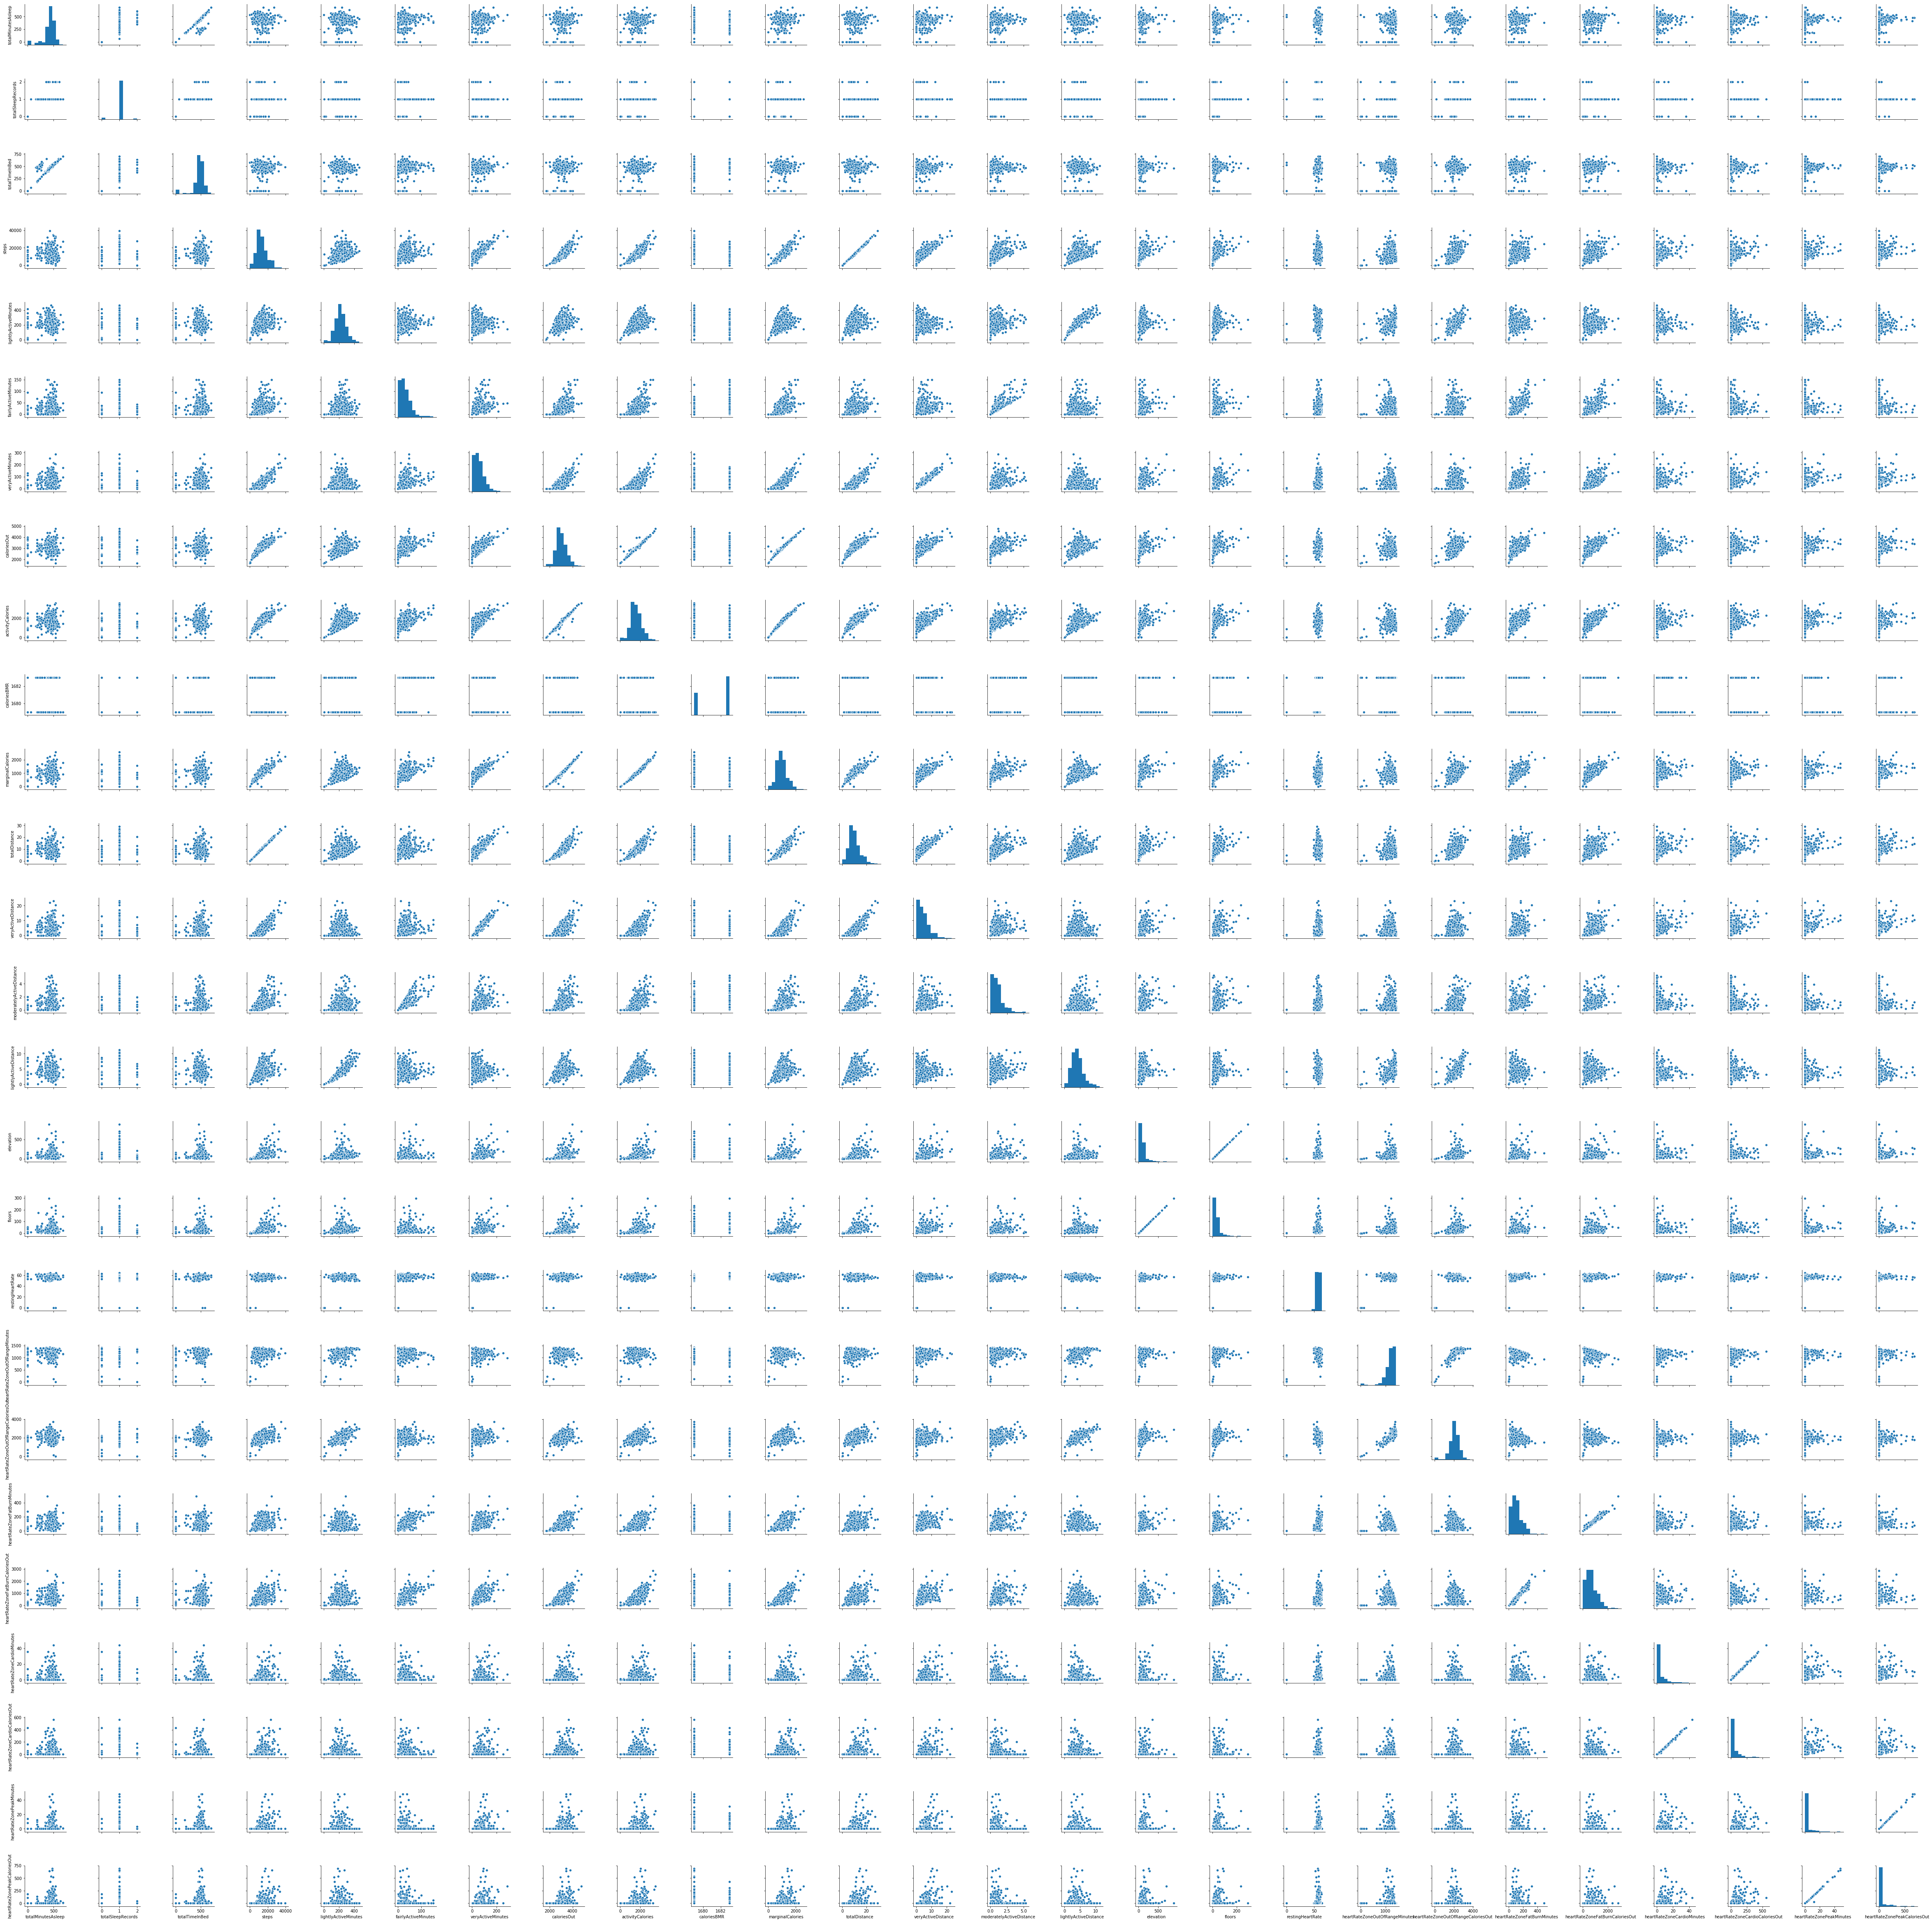

In [16]:
# Get list of all columns except date
column_list_minus_date = fitbit_v1_data.columns.values.tolist()
column_list_minus_date.remove('date')

# Pairplot of everything but date
g = sns.pairplot(fitbit_v1_data[column_list_minus_date])
g.savefig('../output/giant_pair_plot.png')

Well that took a while to process. 

### Eyeballing graphs
Not the most rigorous of methods, but since the only explainable model `sklearn` has and correlation coefficients are boths failing me. 

Looking at the above, I've seen a few things of interest that I'll recreate slightly larger below: 

(0.0, 1.0, 0.0, 1.0)

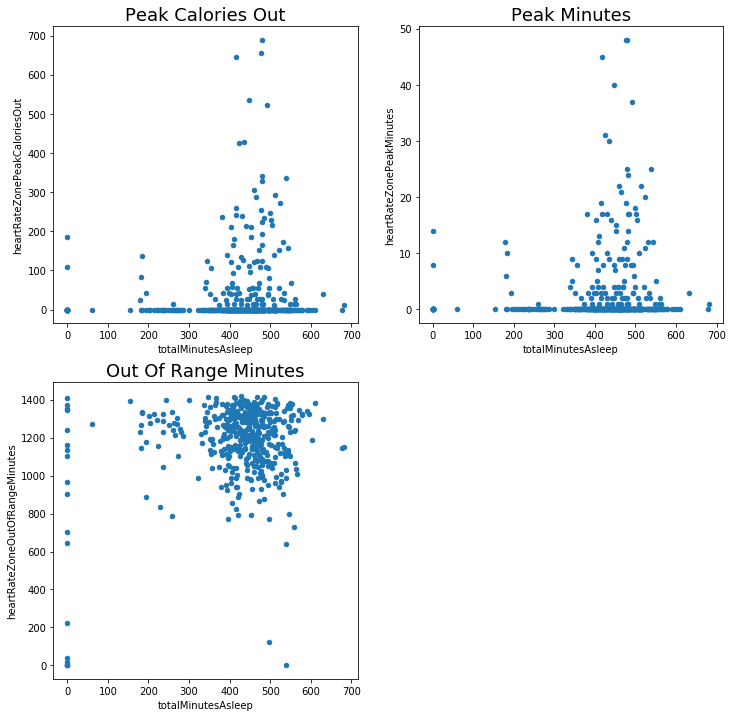

In [17]:
# totalMinutesAsleep vs heartRateZone/Peak/Cardio/CaloriesOut/Minutes
# and totalMinutesAsleep vs heartRateZoneOutOfRangeMinutes
fig, axarr = plt.subplots(2, 2, figsize=(12,12))
fitbit_v1_data.plot.scatter(x='totalMinutesAsleep', 
                            y='heartRateZonePeakCaloriesOut', 
                            ax=axarr[0][0])
axarr[0][0].set_title('Peak Calories Out', fontsize=18)
fitbit_v1_data.plot.scatter(x='totalMinutesAsleep', 
                            y='heartRateZonePeakMinutes', 
                            ax=axarr[0][1])
axarr[0][1].set_title('Peak Minutes', fontsize=18)
fitbit_v1_data.plot.scatter(x='totalMinutesAsleep', 
                            y='heartRateZoneOutOfRangeMinutes', 
                            ax=axarr[1][0])
axarr[1][0].set_title('Out Of Range Minutes', fontsize=18)
axarr[1][1].axis('off')

What I find interesting about the above is that when time spent in peak heart rate (above 163bpm) is above ~20 minutes, sleep time seems to only be in (or close to) acceptable ranges, and when calories out in peak heart rate is above 400, sleep time appears to mostly be not awful. 

What else is interesting is that the total time spent asleep (when nonzero) is less (but still) spread outside the acceptable range when the time spent with heart rate Out Of Range (below 96bpm) is below 1100 minutes (about 18 hours), and further so below ~950 minutes (about 16 hours). 

So basically 'nothing days' result in highly varied, but doing just about anything will increase chances of good amounts of sleep, and having a heart rate over 163bpm for over 20 minutes will help even further. 

Even so, this isn't really useful. Common wisdom (read: google-fu) will tell you way more than that. It took me a while, looking at this, but there really is something that I can get from this data, and _only_ one thing. 

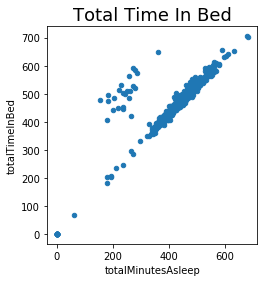

In [18]:
# totalMinutesAsleep vs heartRateZone/Peak/Cardio/CaloriesOut/Minutes
# and totalMinutesAsleep vs heartRateZoneOutOfRangeMinutes
fig = fitbit_v1_data.plot.scatter(x='totalMinutesAsleep', 
                            y='totalTimeInBed')
fig.set_title('Total Time In Bed', fontsize=18)
fig.set_aspect(1)

The only thing this data shows with _any_ certainty is that `totalMinutesAsleep` correlates very strongly with `totalTimeInBed`. This might seem obvious, but I realised that what it means _for me_ is that what really matters is just that I go to be on time! 

I wake up with an alarm (or two; fitbit vibrations and phone noises), at 07:00 every day. That means, if I want to sleep enough, and the only way I _know_ from this data to make that more likely is to be in bed for long enough, then I have to be in bed 8-8.5 hours beforehand, which is 22:30-23:00, and that if I set that as a hard deadline, it will help. 

## Conclusion
Fitbit doesn't provide me with information that is useful for determining what to do in the day in order to ensure good sleep. Instead, I must go to bed on time every day. Not too early, not too late. 

In so far as that we accept common wisdom concerning volumes of different levels of physical activity (where 'common wisdom' means 'exercise a lot' and 'do not sit for too long'), the fitbit hr has failed to provide useful or accurate enough measurements to determine what levels of such are required for enough sleep. 

It should be noted that the fitbit does not measure a number of other crucial variables, such as food intake, water intake, psychological state, injury, light levels, time spent looking at screens in the evening, or mental exertion, and since (annecdotally, I have noticed that) they all have significant effects on my sleep, this doesn't mean there aren't things that can be done during the day to improve sleep, besides a good bed time. 